In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4781,00025119_006.png,Atelectasis,6,25119,064Y,F,AP,3056,2544,0.139,0.139
3366,00016601_001.png,Infiltration,1,16601,006Y,M,PA,2326,2277,0.143,0.143
3150,00015530_152.png,No Finding,152,15530,015Y,M,AP,2500,2048,0.168,0.168


In [25]:
#Creating additional dataframe containing only unique patients
unique_patient_df=all_xray_df.drop_duplicates(subset = 'Patient ID')

# Patient demographics and disease distribution

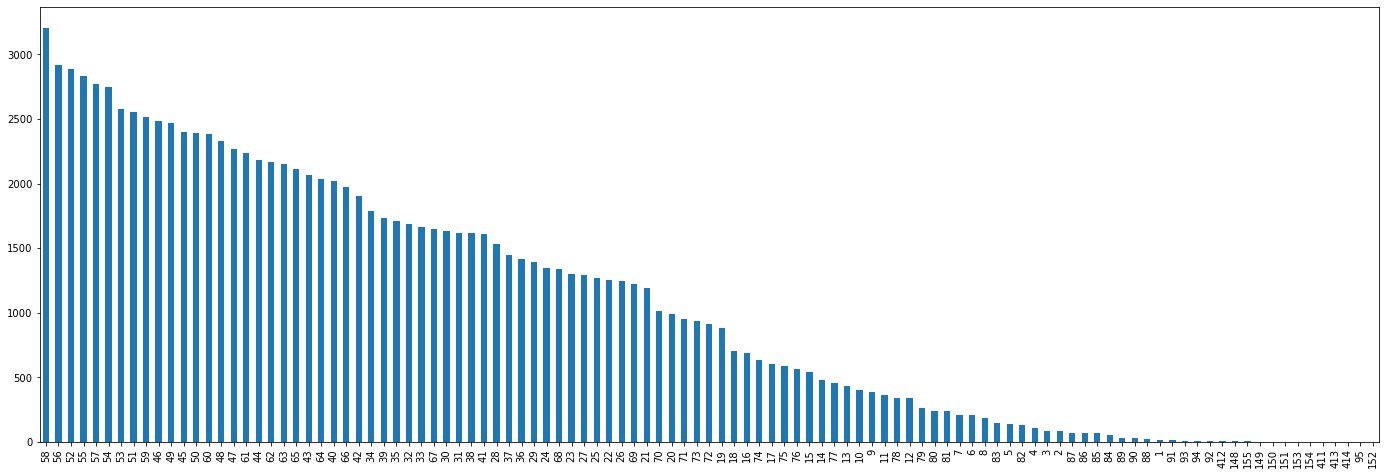

In [24]:
## EDA
all_xray_df['Patient Age'].value_counts().plot(kind='bar', figsize=(24,8))

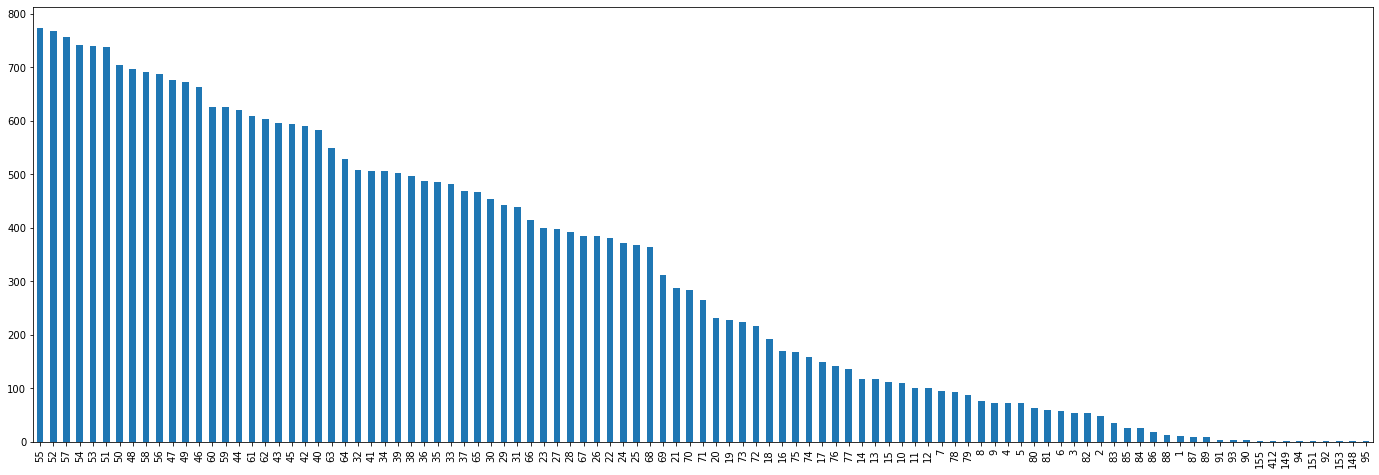

In [26]:
unique_patient_df['Patient Age'].value_counts().plot(kind='bar', figsize=(24,8))

This shows us that the majority of our data is from patients between the age of 40 and 70. Few examples of children. Data also includes some odd outliers that must be data entry errors or signify absent information (Values significantly over 100). Patients in this group are also more likely to appear multiple times in the immage data, likely due to followups.

In [14]:
all_xray_df['Patient Gender'].value_counts()

M    63340
F    48780
Name: Patient Gender, dtype: int64

In [27]:
unique_patient_df['Patient Gender'].value_counts()

M    16630
F    14175
Name: Patient Gender, dtype: int64

Data is fairly balanced on sex, men are somewhat more prevalent but not enough to impact model performance. Men seem to have slighly more entries in the dataset per capita. 

In [10]:
all_xray_df['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

More posterioranterior immages than anteriorposterior immages. Radiologist generally find PA images more useful. If we wish to limit our model to a single view position it should be PA. 

In [20]:
all_xray_df['Finding Labels'].value_counts()

No Finding                                                  60361
Infiltration                                                 9547
Atelectasis                                                  4215
Effusion                                                     3955
Nodule                                                       2705
                                                            ...  
Edema|Effusion|Pleural_Thickening|Pneumonia|Pneumothorax        1
Emphysema|Fibrosis|Mass                                         1
Emphysema|Infiltration|Pneumonia                                1
Mass|Infiltration|Pneumonia                                     1
Consolidation|Emphysema|Mass|Pneumothorax                       1
Name: Finding Labels, Length: 836, dtype: int64

In [21]:
all_xray_df['Finding Labels'].str.contains('Pneumonia').value_counts()

False    110689
True       1431
Name: Finding Labels, dtype: int64

We have only 1431 immages containing pneumonia in our 112120 immage dataset. This will need to be adressed in training. 

In [30]:
pa_xray_df = all_xray_df.drop(all_xray_df.loc[all_xray_df['View Position']=='AP'].index)

In [31]:
pa_xray_df['Finding Labels'].str.contains('Pneumonia').value_counts()

False    66680
True       630
Name: Finding Labels, dtype: int64

Of our PA images only 630 contain pneumonia. 66680 are negative.

In [32]:
unique_patient_df['Finding Labels'].str.contains('Pneumonia').value_counts()

False    30627
True       178
Name: Finding Labels, dtype: int64

And in total we only have 178 patients with a pneumonia diagnosis out of 30627

In [42]:
pneumonia_df= unique_patient_df[unique_patient_df['Finding Labels'].str.contains('Pneumonia')]

In [43]:
pneumonia_df['Finding Labels'].value_counts()

Pneumonia                                                                                         58
Atelectasis|Pneumonia                                                                             32
Infiltration|Pneumonia                                                                            22
Nodule|Pneumonia                                                                                   7
Edema|Infiltration|Pneumonia                                                                       5
Consolidation|Pneumonia                                                                            5
Cardiomegaly|Pneumonia                                                                             3
Mass|Nodule|Pneumonia                                                                              3
Edema|Pneumonia                                                                                    3
Effusion|Pneumonia                                                                         

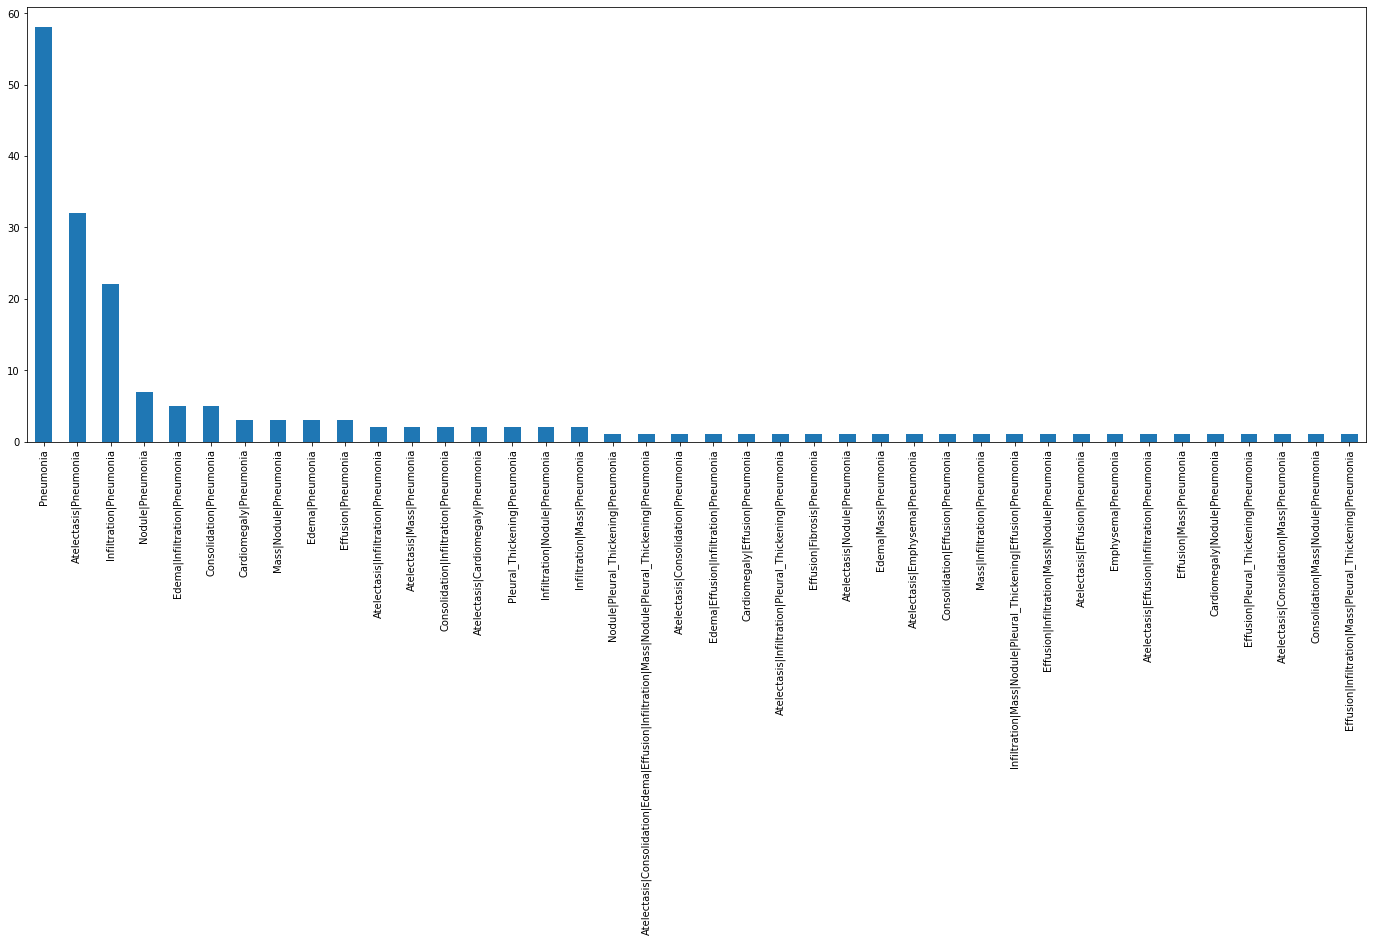

In [44]:
pneumonia_df['Finding Labels'].value_counts().plot(kind='bar', figsize=(24,8))

Pneumonia does appear on it's own most frequently but in total over half of the cases are accompanied by other conditions. Most frequently Atelectasis and Infiltration.

# Pixel-level assessment